In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Images are of size: (3600, 3600)


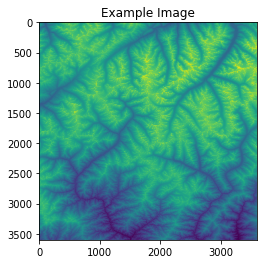

In [254]:
import glob
import random
import skimage
from matplotlib import pyplot as plt

test_file = glob.glob("N035E070_N040E075/N035E070_N040E075/*DSM.tif")[0]

im = skimage.io.imread(test_file)
print("Images are of size:", im.shape)
plt.title("Example Image")
plt.imshow(im)

In [187]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[-2:]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image

In [227]:
# Generate a ton of training images
PATHS = glob.glob("N035E070_N040E075/N035E070_N040E075/*DSM.tif") + \
        glob.glob("N035E075_N040E080/N035E075_N040E080/*DSM.tif")

NUM_BIG = 32
NUM_IMAGES = 4096
NUM_PER = NUM_IMAGES // NUM_BIG
image_paths = PATHS[:NUM_BIG]
rc = RandomCrop(64)
for i in range(NUM_BIG):
    im = skimage.io.imread(image_paths[i])
    for im_num in range(NUM_PER):
        sm_im = skimage.exposure.rescale_intensity(rc(im))
        skimage.io.imsave("images/small/{}_small.tif".format(i * NUM_PER + im_num), sm_im)

0.9999695


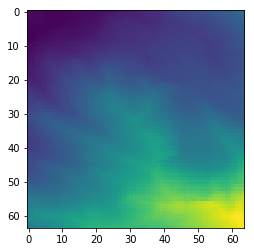

In [53]:
import cv2
image = np.float32(cv2.imread("images/small/0_small.tif", cv2.IMREAD_ANYDEPTH ) / 2**15)
imshow(image)

In [32]:
import PIL
import cv2
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

SEED = 11
BATCH_SIZE = 64
DEVICE = 'cpu'
LEARNING_RATE = 0.2

random.seed(SEED)
torch.manual_seed(SEED)

def loader(path):
    im = np.float32(cv2.imread(path, cv2.IMREAD_ANYDEPTH ) / 2**15)
    return im

dataset = dset.ImageFolder(root="images",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))
                           ]),
                           loader=loader)
print(len(dataset))
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
batch1 = next(iter(dataloader))[0]
print(batch1.shape)
im1 = batch1[0, 0, :, :]
print(im1.shape)
print(im1.max())
print(im1.min())

4096
torch.Size([64, 1, 64, 64])
torch.Size([64, 64])
tensor(0.9999)
tensor(-1.)


In [33]:
ngf = 64 # Number of filters in generator's first layer
nz = 100 # Size of the latent z vector (what the generator uses to create )
nc = 1 # Number of Channels

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is just Z, going into convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,      ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # size: ngf x 32 x 32
            nn.ConvTranspose2d(    ngf,       nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # size: nc x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)
    
netG = Generator().to(DEVICE)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [34]:
ndf = 64 # Number of filters in discriminator's first layer

# Debugging module
class Print(nn.Module):
    def __init__(self, step_num):
        super(Print, self).__init__()
        self.step_num = step_num

    def forward(self, x):
        print(self.step_num, x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Size: nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # size: ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (ndf * 8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)
    
netD = Discriminator().to(DEVICE)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [35]:
fixed_noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=DEVICE)
real_label = 1
fake_label = 0

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

N_EPOCHS = 50

for epoch in range(1, N_EPOCHS+1):
    for i, data in enumerate(dataloader):
        # Update Discriminator network ---
        # Tran with a real image
        netD.zero_grad()
        real_cpu = data[0].to(DEVICE)
        vutils.save_image(real_cpu.detach(), 'testing/real.png')
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=DEVICE)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with a fake image
        noise = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise)
        vutils.save_image(fake.detach(), 'testing/fake.png')
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item() 
        errD = errD_real + errD_fake
        optimizerD.step()
        
        print("SANITY CHECK")
        print("Real max/min:", real_cpu.max().item(), real_cpu.min().item())
        print("Fake max/min:", fake.max().item(), fake.min().item())
        #breakpoint()
        
        # Update Generator network ---
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, N_EPOCHS, i+1, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % 'outputs',
                    normalize=True)
            fake = netG(fixed_noise)
            # print(fake.max(), fake.min())
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % ('outputs', epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('checkpoints', epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('checkpoints', epoch))

SANITY CHECK
Real max/min: 0.99993896484375 -1.0
Fake max/min: 0.8296772241592407 -0.8528715372085571
[1/50][1/64] Loss_D: 1.2722 Loss_G: 29.4230 D(x): 0.6368 D(G(z)): 0.4667 / 0.0000
SANITY CHECK
Real max/min: 0.99993896484375 -1.0
Fake max/min: 0.7841628193855286 -0.831645131111145
[1/50][2/64] Loss_D: 37.5952 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
SANITY CHECK
Real max/min: 0.99993896484375 -1.0
Fake max/min: 0.7917693853378296 -0.8456305265426636
[1/50][3/64] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
SANITY CHECK
Real max/min: 0.99993896484375 -1.0
Fake max/min: 0.8053611516952515 -0.8464085459709167
[1/50][4/64] Loss_D: 28.5641 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
SANITY CHECK
Real max/min: 0.99993896484375 -1.0
Fake max/min: 0.7991101741790771 -0.8519188165664673
[1/50][5/64] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
SANITY CHECK
Real max/min: 0.99993896484375 -1.0
Fake max/min: 0.814599037170

KeyboardInterrupt: 

## Image showing range of both the real and fake image.

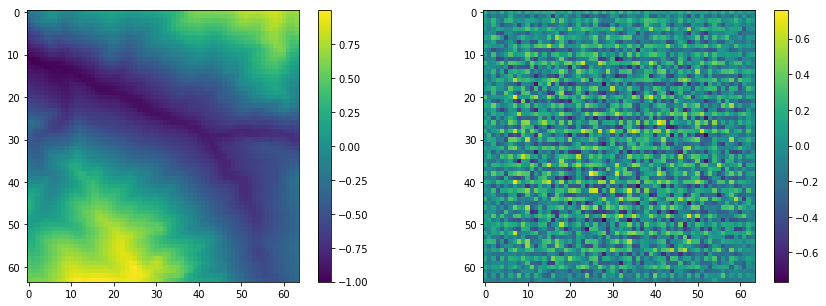

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(real_cpu[0, 0, :, :])
plt.colorbar()

plt.subplot(122)
plt.imshow(fake[0, 0, :, :].detach())
plt.colorbar()
plt.show()

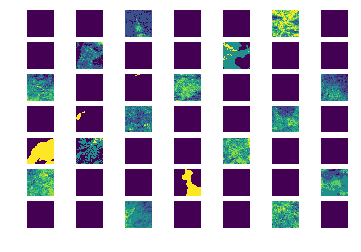

In [94]:
num_images = 49
ncols = int(num_images ** 0.5)
nrows = math.ceil(num_images / ncols)
f, axes = plt.subplots(nrows=nrows, ncols=ncols)
for i in range(ncols * nrows):
    col = i % ncols
    row = i // ncols
    if i <= num_images:
        loaded_im = dataset[i][0].reshape((50, 50))
        axes[row, col].imshow(loaded_im)
    axes[row, col].axis('off')